[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1mUDx4uFpbS6jrD7lN-P7F7saefP_QJ31?usp=sharing)


In [1]:
# Import required packages
!python -m spacy download fr_core_news_sm
#import fr_core_news_sm
import spacy
from spacy import displacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
 

     |████████████████████████████████| 14.7 MB 5.1 MB/s 
  Created wheel for fr-core-news-sm: filename=fr_core_news_sm-2.2.5-py3-none-any.whl size=14727026 sha256=8b14c02e394033fb4b200259c9c242eabed1f7ec274cde85ba2e34a61b86e342
  Stored in directory: /tmp/pip-ephem-wheel-cache-r9oboz18/wheels/c9/a6/ea/0778337c34660027ee67ef3a91fb9d3600b76777a912ea1c24
Successfully built fr-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_sm')


In [57]:
# Import additional packages
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

from spacy.lang.fr.stop_words import STOP_WORDS
from spacy.lang.fr.examples import sentences 
from spacy.lang.fr import French
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [8]:
path = "https://raw.githubusercontent.com/Lirette2/DMML2021_Apple/main/data/training_data.csv"
df = pd.read_csv(path, index_col=0)
df.head()


,sentence,difficulty
id,,
0,Les coûts kilométriques réels peuvent diverger...,C1
1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1
2,Le test de niveau en français est sur le site ...,A1
3,Est-ce que ton mari est aussi de Boston?,A1
4,"Dans les écoles de commerce, dans les couloirs...",B1


In [9]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4800 entries, 0 to 4799
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   sentence    4800 non-null   object
 1   difficulty  4800 non-null   object
dtypes: object(2)
memory usage: 112.5+ KB


In [4]:
# Base rate: the data-set is a bit balanced!
df.difficulty.value_counts()


A1    813
C2    807
C1    798
A2    795
B1    795
B2    792
Name: difficulty, dtype: int64

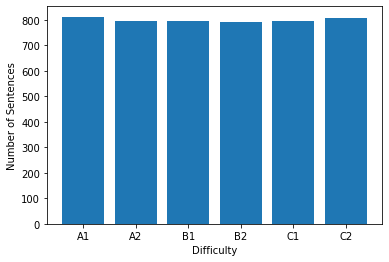

In [10]:
difficulty_count = df.groupby("difficulty").count()
plt.bar(difficulty_count.index.values, difficulty_count["sentence"])
plt.xlabel("Difficulty")
plt.ylabel("Number of Sentences")
plt.show()

In [6]:
round(df.difficulty.value_counts().max()/ len(df), 4)


0.1694

### tokening the date with spaCy


In [11]:
# Create a list of punctuation marks
punctuations = string.punctuation
punctuations

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [12]:
# Create a list of stopwords
#stop_words = spacy.lang.en.stop_words.STOP_WORDS
stop_words = spacy.lang.fr.stop_words.STOP_WORDS

list(stop_words)[:10]

["t'",
 'nôtres',
 'té',
 'hum',
 'pendant',
 'vous-mêmes',
 'tiennes',
 'vive',
 'mes',
 'directe']

In [160]:
# Load French language model
import fr_core_news_sm
#sp = spacy.load('en_core_web_sm')
sp = fr_core_news_sm.load()

# Create tokenizer function
def spacy_tokenizer(sentence):
    # Create token object, which is used to create documents with linguistic annotations.
    mytokens = sp(sentence)

    # Lemmatize each token and convert each token into lowercase
    mytokens = [ word.lemma_.lower().strip() for word in mytokens ]
    ## alternative way
    # mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Remove stop words and punctuation
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # Return preprocessed list of tokens
    return mytokens



In [161]:
# Example
#New_sentence = df["sentence"].sample()
New_sentence = df["sentence"].head()
New_sentence.values[0]
spacy_tokenizer(New_sentence.values[0])


['coût',
 'kilométrique',
 'réel',
 'pouvoir',
 'diverger',
 'sensiblemer',
 'valeur',
 'moyenner',
 'fonction',
 'moyen',
 'transport',
 'utiliser',
 'taux',
 'occupation',
 'taux',
 'remplissage',
 'infrastructure',
 'utiliser',
 'topographie',
 'ligne',
 'flux',
 'trafic',
 'etc.']

In [302]:
#### **** ***************** **** ####
#### **** RAW TEXT FEATURES **** ####
#### **** ***************** **** ####

# Count tokens per sentence
def count_token(sent):
  return(len(spacy_tokenizer(sent))) #spacy_tokenizer() to get tokens, len() to count them

# Count raw words per sentence
def count_words(sent):
  return(len(sent.split())) #split() gives us individual words, len() counts them

#Get average character length of word
def count_avg_word_character(sent):
  words = sent.split()
  return(sum(len(word) for word in words) / len(words))

def count_avg_token_character(sent):
  words = spacy_tokenizer(sent)
  if len(words) == 0:
    return(0)
  else:
    return(sum(len(word) for word in words) / len(words))

In [307]:
#### **** **************** **** ####
#### **** LEXICAL FEATURES **** ####
#### **** **************** **** ####

# Lexical Diversity
def lex_div_word(sent):
  total_number_word = len(sent.split())
  unique = set(sent.split())
  return(len(unique)/total_number_word)
#We don't apply for token, as the goal of the tokenzization is to be left with 
#unique tokens
#For tokens, we should apply to the whole text as done by tfidf_vector

# Lexical Density
def lex_den_tokens(sent):
  st = spacy_tokenizer(sent)
  string = " ".join([str(item) for item in st])
  x = sp(string)
  counter = 0 
  for token in x:
    if token.pos_ == "NOUN" or token.pos_ == "ADJ" or token.pos_ == "VERB" or token.pos_ == "ADV":
      counter = counter + 1
  if len(st) == 0:
    return(0)
  else:
    return(counter/len(st))

def lex_den_words(sent):
  x = sp(sent)
  counter = 0 
  for token in x:
    if token.pos_ == "NOUN" or token.pos_ == "ADJ" or token.pos_ == "VERB" or token.pos_ == "ADV":
      counter = counter + 1
  return(counter/len(x))

# Words NOT in frequent list
path = "https://raw.githubusercontent.com/Lirette2/DMML2021_Apple/main/data/list_words.csv"
words = pd.read_csv(path, index_col=0)


def words_list(sent):
  unique = set(sent.split())
  counter = 0
  for word_in_sentence in unique:
    for word_in_list in words.Mots:
      if word_in_sentence == word_in_list:
        counter = counter + 1
        break#we stop comparing once the word in found, to make it faster
  return(counter/len(unique))


def token_list(sent):
  unique = spacy_tokenizer(sent)
  counter = 0
  for word_in_sentence in unique:
    for word_in_list in words.Mots:
      if word_in_sentence == word_in_list:
        counter = counter + 1
        break#we stop comparing once the word in found, to make it faster
  return(counter/len(unique))


In [308]:
raw_word_count = pd.Series(df.sentence.apply(count_words),name="raw_word_count")
token_count = pd.Series(df.sentence.apply(count_token),name="token_count")
avg_chr_word = pd.Series(df.sentence.apply(count_avg_word_character),name="avg_chr_word")
avg_chr_token = pd.Series(df.sentence.apply(count_avg_token_character),name="avg_chr_token")
diversity_word = pd.Series(df.sentence.apply(lex_div_word),name="diversity_word")
density_word = pd.Series(df.sentence.apply(lex_den_words),name="density_word")
density_token = pd.Series(df.sentence.apply(lex_den_tokens),name="density_token")
freq_word_list = pd.Series(df.sentence.apply(words_not_list),name="freq_word_list")
freq_token_list = pd.Series(df.sentence.apply(words_list),name="freq_token_list")

new_df = pd.concat([df,raw_word_count,token_count,avg_chr_word,avg_chr_token,
                    diversity_word,density_word,density_token,freq_word_list,freq_token_list],axis=1)
new_df

,sentence,difficulty,raw_word_count,token_count,avg_chr_word,avg_chr_token,diversity_word,density_word,density_token,freq_word_list,freq_token_list
id,,,,,,,,,,,
0,Les coûts kilométriques réels peuvent diverger...,C1,38,23,5.736842,7.434783,0.763158,0.488889,0.956522,0.793103,0.206897
1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1,12,5,4.250000,5.400000,1.000000,0.375000,0.400000,0.583333,0.416667
2,Le test de niveau en français est sur le site ...,A1,13,6,4.153846,5.833333,0.923077,0.400000,1.000000,0.500000,0.500000
3,Est-ce que ton mari est aussi de Boston?,A1,8,2,4.125000,5.000000,1.000000,0.400000,0.500000,0.250000,0.750000
4,"Dans les écoles de commerce, dans les couloirs...",B1,34,18,5.176471,5.611111,0.823529,0.380952,0.722222,0.714286,0.285714
...,...,...,...,...,...,...,...,...,...,...,...
4795,"C'est pourquoi, il décida de remplacer les hab...",B2,26,12,5.384615,7.500000,1.000000,0.500000,0.833333,0.576923,0.423077
4796,Il avait une de ces pâleurs splendides qui don...,C1,21,10,4.666667,5.700000,0.952381,0.454545,1.000000,0.750000,0.250000
4797,"Et le premier samedi de chaque mois, venez ren...",A2,14,6,4.785714,6.666667,0.928571,0.466667,1.000000,0.538462,0.461538


In [309]:
#Scale the data
scaler = MinMaxScaler()
col_to_scale = ["raw_word_count","token_count","avg_chr_word","avg_chr_token"]
#no need for the others because they already are on a scale from 0 to 1

new_df[col_to_scale]= scaler.fit_transform(new_df[col_to_scale])
new_df

,sentence,difficulty,raw_word_count,token_count,avg_chr_word,avg_chr_token,diversity_word,density_word,density_token,freq_word_list,freq_token_list
id,,,,,,,,,,,
0,Les coûts kilométriques réels peuvent diverger...,C1,0.140152,0.184,0.339713,0.619565,0.763158,0.488889,0.956522,0.793103,0.206897
1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1,0.041667,0.040,0.204545,0.450000,1.000000,0.375000,0.400000,0.583333,0.416667
2,Le test de niveau en français est sur le site ...,A1,0.045455,0.048,0.195804,0.486111,0.923077,0.400000,1.000000,0.500000,0.500000
3,Est-ce que ton mari est aussi de Boston?,A1,0.026515,0.016,0.193182,0.416667,1.000000,0.400000,0.500000,0.250000,0.750000
4,"Dans les écoles de commerce, dans les couloirs...",B1,0.125000,0.144,0.288770,0.467593,0.823529,0.380952,0.722222,0.714286,0.285714
...,...,...,...,...,...,...,...,...,...,...,...
4795,"C'est pourquoi, il décida de remplacer les hab...",B2,0.094697,0.096,0.307692,0.625000,1.000000,0.500000,0.833333,0.576923,0.423077
4796,Il avait une de ces pâleurs splendides qui don...,C1,0.075758,0.080,0.242424,0.475000,0.952381,0.454545,1.000000,0.750000,0.250000
4797,"Et le premier samedi de chaque mois, venez ren...",A2,0.049242,0.048,0.253247,0.555556,0.928571,0.466667,1.000000,0.538462,0.461538


## classification of level using logistic regression

In [310]:
# Select features
X = new_df[["sentence","raw_word_count","token_count","avg_chr_word","avg_chr_token",
                    "diversity_word","density_word","density_token","freq_word_list",
            "freq_token_list"]]# the features we want to analyze

ylabels = new_df['difficulty'] # the labels, or answers, we want to test against

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.2, random_state=1234, stratify=ylabels)

X_train

,sentence,raw_word_count,token_count,avg_chr_word,avg_chr_token,diversity_word,density_word,density_token,freq_word_list,freq_token_list
id,,,,,,,,,,
962,Le réalisateur m'a d'abord demandé de me mettr...,0.037879,0.032,0.272727,0.645833,1.000000,0.428571,1.000000,0.545455,0.454545
1886,"Après quelques mois de cette pauvreté noble, a...",0.109848,0.112,0.266667,0.517857,0.966667,0.352941,0.714286,0.586207,0.413793
2721,L'indicateur n'était que de 40% chez les femme...,0.034091,0.040,0.245455,0.483333,1.000000,0.357143,0.600000,0.600000,0.400000
1025,L'objectif de ce type de voyage est d'être act...,0.094697,0.096,0.241259,0.527778,0.923077,0.482759,1.000000,0.375000,0.625000
4048,"Et, en France, beaucoup moins de filles que de...",0.083333,0.080,0.276680,0.500000,0.956522,0.384615,0.500000,0.636364,0.363636
...,...,...,...,...,...,...,...,...,...,...
3693,Je vais prendre ma douche dans ma salle-de-bain.,0.026515,0.032,0.284091,0.645833,0.875000,0.333333,0.750000,0.714286,0.285714
3408,"Après l'éruption de 1754, la plus grosse connu...",0.132576,0.128,0.275253,0.546875,0.805556,0.380952,0.625000,0.655172,0.344828
4289,Léonard est initié par Verrocchio aux nombreus...,0.117424,0.120,0.369318,0.644444,0.937500,0.472222,0.866667,0.666667,0.333333


In [311]:
y_train


id
962     B1
1886    C1
2721    A2
1025    B1
4048    B2
        ..
3693    A1
3408    B1
4289    C2
3312    C2
269     A1
Name: difficulty, Length: 3840, dtype: object

In [312]:
from sklearn.compose import ColumnTransformer

# Define classifier
classifier = LogisticRegression(multi_class="multinomial",max_iter=1000)

#Vectorizer
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer)

#Column Transformer (to apply vectorizer to the right column)
column_transformer = ColumnTransformer(
    [("tfidf", tfidf_vector, "sentence")],
    remainder="passthrough")

# Create pipeline
pipe = Pipeline([("tfidf",column_transformer),("classifier", classifier)])

# Fit model on training set
pipe.fit(X_train, y_train)


Pipeline(steps=[('tfidf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tfidf',
                                                  TfidfVectorizer(tokenizer=<function spacy_tokenizer at 0x7f44f63848c0>),
                                                  'sentence')])),
                ('classifier',
                 LogisticRegression(max_iter=1000, multi_class='multinomial'))])

In [290]:
# Evaluate the model
def evaluate(test, pred):
  precision = precision_score(test, pred,average=None)
  recall = recall_score(test, pred, average=None)
  f1= f1_score(test, pred, average=None)
  print(f'CONFUSION MATRIX:\n{confusion_matrix(test, pred)}')
  print(f"ACCURACY SCORE:\n{accuracy_score(test, pred) :.4f}")
  print(f'CLASSIFICATION REPORT:')
  print("Precision:\t {0:4f}".format(precision_score(test, pred,average="macro"))) 
  print("Recall:\t {0:4f}".format(recall_score(test, pred, average="macro")))
  print("F1_Score:\t {0:4f}".format(f1_score(test, pred, average="macro")))


In [313]:
# Predictions
y_pred = pipe.predict(X_test)

# Evaluation - test set
evaluate(y_test, y_pred)

CONFUSION MATRIX:
[[101  27  25   8   1   1]
 [ 44  61  45   4   4   1]
 [ 20  40  64  19   8   8]
 [  6   7  18  69  28  30]
 [  4   3  10  36  71  36]
 [  3   0  12  21  30  95]]
ACCURACY SCORE:
0.4802
CLASSIFICATION REPORT:
Precision:	 0.478718
Recall:	 0.479386
F1_Score:	 0.478020


In [314]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
random_for=RandomForestClassifier(n_estimators=100)

pipe = Pipeline([("tfidf",column_transformer),("model", random_for)])
#Train the model using the training sets y_pred=clf.predict(X_test)
pipe.fit(X_train,y_train)

y_pred=pipe.predict(X_test)
evaluate(y_test, y_pred)

CONFUSION MATRIX:
[[118  27  16   2   0   0]
 [ 51  67  37   3   1   0]
 [ 24  44  68  10   7   6]
 [  8   3  26  65  35  21]
 [ 10   7  14  34  68  27]
 [  3   5  18  27  42  66]]
ACCURACY SCORE:
0.4708
CLASSIFICATION REPORT:
Precision:	 0.470773
Recall:	 0.469886
F1_Score:	 0.466148
